## This notebook is specifically to show the anharmonic effects that are corrected after the multiple scattering correction for DLIO

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import matplotlib
from mantid.simpleapi import *
import matplotlib.patheffects as PathEffects
import matplotlib.patheffects as PathEffects

sys.path.append("../python scripts/")


from nxspetomd import *
from genslices import *
import MDUtils as mdu
from getcolor import *
import lmfit
from lmfit import Model
from mdfactorization import *
from submultscatt import *
from tempsubtract import * 
from cut_mdhisto_powder import *
#Style sheet updates 
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['font.size']=10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='serif'
%matplotlib inline

FrameworkManager-[Notice] Welcome to Mantid 6.7.0
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.7
CheckMantidVersion-[Notice] A new version of Mantid(6.8.0) is available for download from https://download.mantidproject.org


In [2]:
#First import data. 
#Vanadium normalization factors, per Ir
# for Ei=30meV FC2=300Hz
van_factor_30 = 12371.854349376017
# For Ei=60meV FC2=420Hz
van_factor_60 = 8734.4

# for Ei=30meV FC2=300Hz
van_factor_30 =  45602.6555# mbarn/meV/sr/ mol (Li2IrO3)

fu_hlio_over_lio = 0.0074 / 0.015 # from 3.6g hlio to 3.8g beta-lio
van30_permolfu_hlio = van_factor_30*fu_hlio_over_lio
van_factor_30 = van30_permolfu_hlio / 2.0 # per Ir 
# For Ei=60meV FC2=420Hz 
van_factor_60 = 32195.135
van_factor_60 = van_factor_60*fu_hlio_over_lio / 2.0 

print(f"Normalization for Ei=30 meV : {van_factor_30:.2e}")
print(f"Normalization for Ei=60 meV : {van_factor_60:.2e}")

ei30_100K = 'data/ei30_100K_manualmask.nxspe'
ei30_4K = 'data/ei30_4K_manualmask.nxspe'
ei30_200K = 'data/ei30_200K_manualmask.nxspe'
ei60_4K = 'data/ei60_4K_manualmask.nxspe'
ei60_100K = 'data/ei60_100K_manualmask.nxspe'
ei60_200K = 'data/ei60_200K_manualmask.nxspe'

keys = ['30_4K','30_100K','30_200K','60_4K','60_100K','60_200K']
Q30 = GenQslice(0,3.5,100)
E30 = GenEslice(-30,30,120)

Q60 = GenQslice(0,5,100)
E60 = GenEslice(-60,60,180)

f_dict = {keys[0]:ei30_4K,keys[1]:ei30_100K,keys[2]:ei30_200K,keys[3]:ei60_4K,keys[4]:ei60_100K,keys[5]:ei60_200K}
Ei_dict = {keys[0]:30.0,keys[1]:30.0,keys[2]:30.0,keys[3]:60.0,keys[4]:60.0,keys[5]:60.0}

for key in keys:
    if Ei_dict[key]==30.0:
        Qbin,Ebin = Q30,E30
        van = van_factor_30
    else:
        Qbin,Ebin = Q60,E60
        van = van_factor_60
    ws = NxspeToMDHisto(f_dict[key],Qbins=Qbin,Ebins=Ebin,numEvNorm=True,van_factor=van)
    ws_norm = NxspeToMD(f_dict[key],van_factor=van)
    #Be wary that if intensities are normalized to events here mantid will not project properly in matplotlib
    CloneWorkspace(ws,OutputWorkspace=key)
    CloneWorkspace(ws_norm,OutputWorkspace=key+'_event')

Normalization for Ei=30 meV : 1.12e+04
Normalization for Ei=60 meV : 7.94e+03
LoadNXSPE-[Notice] LoadNXSPE started
DownloadInstrument-[Notice] All instrument definitions up to date
LoadNXSPE-[Notice] LoadNXSPE successful, Duration 0.06 seconds
ConvertToMD-[Notice] ConvertToMD started
ConvertToMD-[Notice] ConvertToMD successful, Duration 0.03 seconds
BinMD-[Notice] BinMD started
BinMD-[Notice] BinMD successful, Duration 0.00 seconds
CreateMDHistoWorkspace-[Notice] CreateMDHistoWorkspace started
CreateMDHistoWorkspace-[Notice] CreateMDHistoWorkspace successful, Duration 0.03 seconds
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duration 0.00 seconds
MultiplyMD-[Notice] MultiplyMD started
MultiplyMD-[Notice] MultiplyMD successful, Duration 0.00 seconds
LoadNXSPE-[Notice] LoadNXSPE started
LoadNXSPE-[Notice] LoadNXSPE successful, Duration 0.03 seconds
ConvertToMD-[Notice] ConvertToMD sta

## Perform a simple correction for the Debye-Waller factor using the elastic line.

The elastic scattering should simply be a combination of incoherent and Bragg scattering, such that 

$I(Q) = e^{-\langle u^2 \rangle Q^2} (N\frac{(2\pi )^3}{V_0})) \sum_{HKL}|F_{HKL}(Q)|^2 + \frac{\sigma_{i}}{4\pi})$

Using the scattering away from Bragg peaks should then provide a good measure of the Debye Waller factor. If the Debye-Waller factor is mainly reflecting the motion of Hydrogen, then it also is also safe to assume that this factor applies to inelastic processes that are also dominated by Hydrogen spin-incoherent multiple scattering. 

CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 79
    # data points      = 1
    # variables        = 2
    chi-square         = 1244629.69
    reduced chi-square = 1244629.69
    Akaike info crit   = 18.0343486
    Bayesian info crit = 14.0343486
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    usqr:  0.00330638 (init = 0.003)
    C:    -5.81022535 (init = 0)
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
C

(0.0, 20.0)

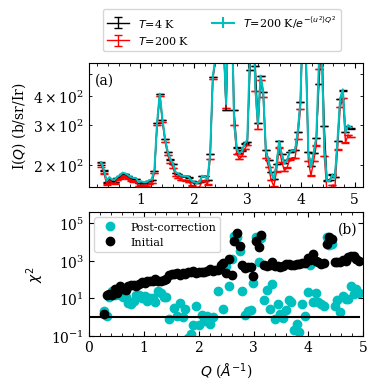

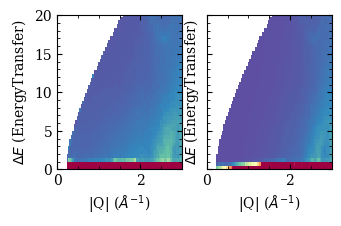

In [3]:
# First, we assume that the value of <u^2> at 4 K is functionally zero
def scale_dw(q,i,err,usqr,C):
    ufac=1.0/np.exp(-usqr*q**2)
    return i*ufac-C,err*ufac

def chisqr_dw(params,q,ilow,errlow,ihigh,errhigh,minQ=1):
    usqr=params['usqr'].value
    C=params['C'].value
    scaled_high,scaled_err = scale_dw(q,ihigh,errhigh,usqr,C)
    diff = np.abs(ilow-scaled_high)**2
    good_i = ~np.isnan(diff)
    diff=diff[good_i]
    scaled_err = scaled_err[good_i]
    errlow=errlow[good_i]
    errlow[q[good_i]<minQ]=1e8
    chisqr = np.sum(diff/np.sqrt(errlow**2+scaled_err**2))
    num = len(good_i)
    chisqr/=num
    return chisqr

def scale_ws_dw(ws,usqr):
    I = np.copy(ws.getSignalArray())
    Err = np.sqrt(np.copy(ws.getErrorSquaredArray()))
    dims = ws.getNonIntegratedDimensions()
    q,u=mdu.dim2array(dims[0]),mdu.dim2array(dims[1])
    Q,E =np.meshgrid(q,u)
    Q=Q.T
    E=E.T
    dw_mesh = 1.0/np.exp(-usqr*Q**2)
    I*=dw_mesh
    Err*=dw_mesh
    out_ws = CloneWorkspace(ws,OutputWorkspace="WS_temp")
    out_ws.setSignalArray(I)
    out_ws.setErrorSquaredArray(Err**2)
    return out_ws

dw_md_dict = {}
ws_low = mtd['60_4K'].clone() #Use 60 meV scattering for larger Q-access
ws_100 = mtd['60_100K']
ws_200 = mtd['60_200K']
ws_high=ws_200.clone()
e_elastic = [-0.5,0.5]
dims = ws_low.getNonIntegratedDimensions()
q,e  = mdu.dim2array(dims[0]),mdu.dim2array(dims[1])
qres = np.abs(q[1]-q[0])
qcut = [np.min(q),np.max(q),qres]

#elastic cuts for the 200 K Debye waller factor
q_low,i_low,err_low=cut_MDHisto_powder(ws_low,'|Q|',qcut,e_elastic)
q_high,i_high,err_high=cut_MDHisto_powder(ws_high,'|Q|',qcut,e_elastic)

params=lmfit.Parameters()
params.add('usqr',value=0.003,min=0.0,max=0.01)
params.add('C',value=0.0,vary=True,min=-50,max=150)

#Fit for an optimal value of usqr
result = lmfit.minimize(chisqr_dw,params=params,method='powell',\
                       kws={'q':q_low,'ilow':i_low,'errlow':err_low,\
                           'ihigh':i_high,'errhigh':err_high})
print(lmfit.fit_report(result))
usqr_high = result.params['usqr'].value
C_high = result.params['C'].value

#Scale the MDhistoworkspaces here. 
ws_db_60_200 = scale_ws_dw(mtd['60_200K'],usqr_high)
ws_db_30_200 = CloneWorkspace(ws_db_60_200,OutputWorkspace='60_200K_DB')

ws_db_30_200 = scale_ws_dw(mtd['30_200K'],usqr_high)
ws_db_60_200 = CloneWorkspace(ws_db_30_200,OutputWorkspace='30_200K_DB')

dw_md_dict['60_200K']=ws_db_60_200
dw_md_dict['30_200K']=ws_db_30_200

#Construct a plot for the SI to show the scaling. 

fig,ax = plt.subplots(2,1,figsize=(3.54,3.54))
ax[0].errorbar(q_low,i_low,err_low,color='k',capsize=3,lw=1,label='$T$=4 K')
ax[0].errorbar(q_high,i_high,err_high,color='r',capsize=3,lw=1,label='$T$=200 K')
chisqr = np.abs(i_low-i_high)**2 / np.sqrt(err_low**2+err_high**2)
ax[1].errorbar(q_low,chisqr,color='k',marker='o',ls=' ',capsize=3,lw=1,label='Initial')

i_high,err_high = scale_dw(q_high,i_high,err_high,usqr_high,C_high)
ax[0].errorbar(q_high,i_high,err_high,color='c',label=r'$T$=200 K/$e^{- \langle u^2 \rangle Q^2}$')

chisqr = np.abs(i_low-i_high)**2 / np.sqrt(err_low**2+err_high**2)
ax[1].plot(q_low,chisqr,color='c',marker='o',ls=' ',label='Post-correction')
ax[1].plot(np.linspace(0,np.max(q_low),1000),1.0+np.zeros(1000),'k-')
ax[0].set_ylim(160,560)
ax[1].set_ylim(0.1,4e5)
ax[0].set_yscale('log')

ax[1].set_yscale('log')
ax[1].set_xlim(0,5.0)

ax[0].legend(loc=(0.05,1.1),ncol=2,fontsize=8)
ax[1].legend(ncol=1,fontsize=8)

ax[0].set_ylabel('I($Q$) (b/sr/Ir)')
ax[1].set_ylabel('$\chi^2$')
ax[1].set_xlabel('$Q$ ($\AA^{-1}$)')

ax[0].text(0.02,0.92,'(a)',transform=ax[0].transAxes,horizontalalignment='left',verticalalignment='top')
ax[1].text(0.98,0.92,'(b)',transform=ax[1].transAxes,horizontalalignment='right',verticalalignment='top')

fig.savefig('HLIO_DW_fact.pdf',bbox_inches='tight')
#Now repeat for 100 K. 
ws_low = mtd['60_4K'] #Use 60 meV scattering for larger Q-access
ws_100 = mtd['60_100K']
ws_200 = mtd['60_200K']
ws_high=ws_100
e_elastic = [-0.5,0.5]
dims = ws_low.getNonIntegratedDimensions()
q,e  = mdu.dim2array(dims[0]),mdu.dim2array(dims[1])
qres = np.abs(q[1]-q[0])
qcut = [np.min(q),np.max(q),qres]

#elastic cuts for the 200 K Debye waller factor
q_low,i_low,err_low=cut_MDHisto_powder(ws_low,'|Q|',qcut,e_elastic)
q_high,i_high,err_high=cut_MDHisto_powder(ws_high,'|Q|',qcut,e_elastic)

params=lmfit.Parameters()
params.add('usqr',value=0.001,min=0.0,max=0.01)
params.add('C',value=0.0,vary=True,min=-50,max=150)

#Fit for an optimal value of usqr
result = lmfit.minimize(chisqr_dw,params=params,method='powell',\
                       kws={'q':q_low,'ilow':i_low,'errlow':err_low,\
                           'ihigh':i_high,'errhigh':err_high})
print(lmfit.fit_report(result))
usqr_high = result.params['usqr'].value
C_high = result.params['C'].value

#Scale the MDhistoworkspaces here. 
ws_db_60_100 = scale_ws_dw(mtd['60_100K'],usqr_high)
ws_db_30_100 = CloneWorkspace(ws_db_60_100,OutputWorkspace='60_100K_DB')

ws_db_30_100 = scale_ws_dw(mtd['30_100K'],usqr_high)
ws_db_60_100 = CloneWorkspace(ws_db_30_100,OutputWorkspace='30_100K_DB')

dw_md_dict['60_100K']=ws_db_60_100
dw_md_dict['30_100K']=ws_db_30_100

#Finally, add the low T
ws_db_30_4 = CloneWorkspace(mtd['30_4K'],OutputWorkspace='30_4K_DB')
ws_db_60_4 = CloneWorkspace(mtd['60_4K'],OutputWorkspace='60_4K_DB')

dw_md_dict['30_4K']=ws_db_30_4
dw_md_dict['60_4K']=ws_db_60_4

testmd = mtd['30_200K_DB']-mtd['30_200K']

fig,ax = plt.subplots(1,2,figsize=(3.54,2),subplot_kw={'projection':'mantid'},sharex=True,sharey=True)
ax[0].pcolormesh(mtd['30_200K'],vmin=0,vmax=15,cmap='Spectral_r')
ax[1].pcolormesh(testmd,vmin=0,vmax=0.5,cmap='Spectral_r')
ax[0].set_xlim(0,3.0)
ax[0].set_ylim(0,20.0)

## Model of the scattering is the following:

$I(Q,\omega) = I_{mag} + I_{ph}^{1} + I^m$

Where $I^m$ is the purely multiple scattering and $I_{ph}^{1}$ is the pure single-phonon scattering. As the single-phonon scattering is the dominant background process, we subtract it using the following form.

$\bar{I}(Q,\omega)=I_{4K} - \frac{1-e^{-\beta_H \omega}}{1-e^{-\beta_L \omega}}I_{100K}$

where $\beta_T = 1/k_BT$.

This is also equal to the following, assuming that there is no magnetic scattering at high T

$\bar{I}(Q,\omega) = I_{mag} +I^m_{4K} -  \frac{1-e^{-\beta_H \omega}}{1-e^{-\beta_L \omega}} I^m_{200K}$

From T. Hong et al we know that the form of $I^m$ is

$I^m(Q,\omega) = f(\omega)(k_i^2 + k_f^2)(\frac{TQ^2}{k_i^2 + k_f^2} + (1-T))$. 



Using a factorization, $f(\omega)$ may be found at each temperature. Then, a multiple scattering background term from the temperature-subtracted data may be defined. 

$I^m_{bkg}(Q,\omega) = I^m_{4 K} - \frac{1-e^{-\beta_H \omega}}{1-e^{-\beta_L \omega}} I^m_{200K}$

Finally, an overall normalization $A$ should be applied to this background such that regimes with no expected magnetic scattering (High $Q$ and high energy transfers) subtract closely to zero. 

$I_{mag}(Q,\omega) = \bar{I}(Q,\omega)-AI^m_{bkg}(Q,\omega)$

In [4]:
#Explanation of the multiple scattering process is found in another notebook. Use extracted T value. 

T_30 = 0.8987225644344023
T_60 = 0.9104801128990222

#Get f(omega) for the first measurement as an example, rest are done within function.
#From here on we use the MDHistoworkspaces. 
title_dict = {keys[0]:'T=4 K',keys[1]:'T=100 K',keys[2]:'T=200 K',\
              keys[3]:'T=4 K',keys[4]:'T=100 K',keys[5]:'T=200 K'}
T=T_30
factorizeDOS=True

#Dictionaries storing results of factorizations. Disable fast_mode if you need full error bars, but 
#  not needed in this analysis and very slow. 
fq_dict = {} #Stores lists of [q,fq,fqerr]
dos_dict = {} #Stores lists of [e,ge,geerr]

for key in keys:
    Ei = Ei_dict[key]
    if Ei==30.0:
        qrange_dos30=[2.0,2.8]
        erange_dos30=[1.5,23]
        #norm_qrange=[2.5,3.0]
        #norm_erange=[4.0,20.0]
        qrange_dos = qrange_dos30
        erange_dos = erange_dos30
        norm_qrange=qrange_dos
        norm_erange=erange_dos
    else:
        qrange_dos60=[1.5,4.0]
        erange_dos60=[4.0,50.0]
        #norm_qrange=[3.5,4.0]
        #norm_erange=[4,50.0]
        qrange_dos = qrange_dos60
        erange_dos = erange_dos60
        norm_qrange=qrange_dos
        norm_erange=erange_dos
        
    q,sq,sq_err,e,ge,ge_err = MDfactorization(mtd[key+"_DB"],mag_ion='Ir4',q_lim=qrange_dos,e_lim=erange_dos,\
                                    Ei=Ei,twoThetaMin=3.5,plot_result=False,method='powell',\
                                    fname='placeholder.txt',\
                            fast_mode=True,overwrite_prev=True,allow_neg_E=True,g_factor=2.0)
    #These factorizations are normalized such that the integrated g(omega) = 1.
    #To make it a background, normalize the factorization to a cut. These are functionally identical. 
    ecut,icut,errcut = cut_MDHisto_powder(mtd[key+"_DB"],'DeltaE',[erange_dos[0],erange_dos[1],np.abs(e[1]-e[0])],\
                                         qrange_dos)
    ge_int = np.trapz(ge,x=e)
    cut_int = np.trapz(icut,x=ecut)
    ratio = ge_int/cut_int 
    dos,dos_err = ge/ratio,ge_err/ratio
    #Uncomment to use cuts rather than factorizations. 
    e,dos, dos_err = ecut,icut, errcut
    dos_dict[key]=[e,dos,dos_err]
    fq_dict[key]=[q,sq,sq_err]
    #Save a plot of factorization and cut to look at later 
    fig,ax = plt.subplots(1,2,subplot_kw={'projection':'mantid'},figsize=(3.54,2.5))
    ax[1].errorbar(dos,e,xerr=dos_err*0.0,color='k',marker='o',mfc='w',mec='k',label='$G(\omega)$',ms=3,ls=' ')
    ax[1].errorbar(icut,ecut,xerr=errcut,color='k',marker='s',mfc='k',mec='k',label='I($\omega$)',ms=3,ls=' ')
    ax[0].set_title(title_dict[key])
    ax[1].set_xlabel('$f(\omega)$ (a.u.)')
    ax[1].set_ylabel('')
    ax[1].legend()
    ax[0].pcolormesh(mtd[key],vmin=0,vmax=np.nanmax(dos),cmap='Spectral_r',rasterized=True)
    ax[0].set_ylim(0,Ei*0.9)
    ax[0].text(0.05,0.95,'(a)',transform=ax[0].transAxes,horizontalalignment='left',verticalalignment='top')
    ax[1].text(0.05,0.05,'(b)',transform=ax[1].transAxes,horizontalalignment='left',verticalalignment='bottom')
    
    fig.savefig('fomega_plots/'+key+'_factorization.png',bbox_inches='tight',dpi=300)
    fig.savefig('fomega_plots/'+key+'_factorization.pdf',bbox_inches='tight',dpi=300)

    plt.close('all')


CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.03 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.00 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.03 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.01 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.02 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.01 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.02 seconds
MagFormFactorCorrection-[Notice] Mag

# Calculate $\bar{I}$ using 200 K data as a nonmagnetic background


CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace s

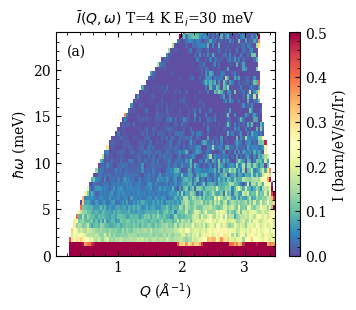

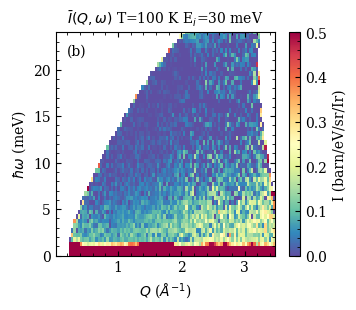

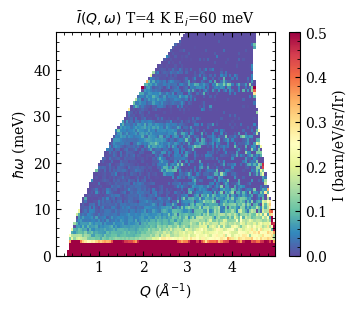

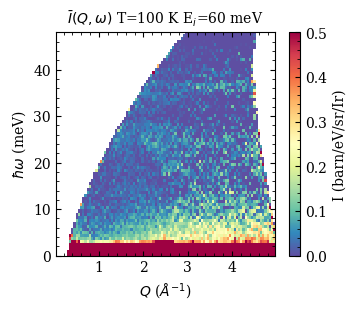

In [5]:
Ibar_dict = {}
titlestrs ={'30_4K':r'$\bar{I}(Q,\omega)$ T=4 K E$_i$=30 meV',\
            '30_100K':r'$\bar{I}(Q,\omega)$ T=100 K E$_i$=30 meV',\
            '60_4K':r'$\bar{I}(Q,\omega)$ T=4 K E$_i$=60 meV',\
            '60_100K':r'$\bar{I}(Q,\omega)$ T=100 K E$_i$=60 meV'}
for key in  ['30_4K','30_100K','60_4K','60_100K']:
    Ei = Ei_dict[key]
    if Ei==30 and '4K' in key:
        highT_key = '30_200K'
        thigh = 200.0
    if Ei==30 and '100K' in key:
        highT_key = '30_200K'
        thigh=200.0
    if Ei==60.0 and '4K' in key:
        highT_key = '60_200K'
        thigh = 200.0
    if Ei==60.0 and '100K' in key:
        highT_key = '60_200K'
        thigh=200.0
    if '4K' in key:
        tlow = 4.0
    else:
        tlow = 100.0
    ylims = [0,0.8*Ei]
    Ibar = tempsubtract_cut2D(mtd[key+"_DB"],mtd[highT_key+"_DB"],tlow,thigh)
    Ibar = CloneWorkspace(Ibar,OutputWorkspace=key+'_bar')
    Ibar_dict[key]=Ibar
    #Save a plot of this. 
    fig,ax = plt.subplots(1,1,subplot_kw={"projection":"mantid"},figsize=(3.54,2.9))
    mesh=ax.pcolormesh(Ibar,vmin=0,vmax=0.5,cmap='Spectral_r',rasterized=True)
    fig.colorbar(mesh,label='I (barn/eV/sr/Ir)')
    ax.set_title(titlestrs[key],fontsize=10)
    ax.set_xlabel('$Q$ ($\AA^{-1}$)')
    ax.set_ylabel('$\hbar\omega$ (meV)')
    ax.set_ylim(*ylims)
    if key=='30_4K':
        ax.text(0.05,0.95,'(a)',transform=ax.transAxes,horizontalalignment='left',verticalalignment='top')
    if key=='30_100K':
        ax.text(0.05,0.95,'(b)',transform=ax.transAxes,horizontalalignment='left',verticalalignment='top')
    fig.savefig('Ibar_plots/Ibar_'+key+'.pdf',bbox_inches='tight',dpi=300)
    #plt.close('all')
    

## Using previously generated ${\cal T}$ values and factorizations, calculate $I^m_{bkg}$

$I^m_{bkg}(Q,\omega) = f^{4K}(\omega)(k_i^2 + k_f^2)(\frac{TQ^2}{k_i^2 + k_f^2} + (1-{\cal T})) - \frac{1-e^{-\beta_H \omega}}{1-e^{-\beta_L \omega}}f^{200K}(\omega)(k_i^2 + k_f^2)(\frac{TQ^2}{k_i^2 + k_f^2} + (1-{\cal T}))$


CreateMDHistoWorkspace-[Notice] CreateMDHistoWorkspace started
CreateMDHistoWorkspace-[Notice] CreateMDHistoWorkspace successful, Duration 0.00 seconds
Scale for 30_4K = 0.1501
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duration 0.00 seconds
MultiplyMD-[Notice] MultiplyMD started
MultiplyMD-[Notice] MultiplyMD successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CreateMDHistoWorkspace-[Notice] CreateMDHistoWorkspace started
CreateMDHistoWorkspace-[Notice] CreateMDHistoWorkspace successful, Duration 0.00 seconds
Scale for 30_100K = 0.1501
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duration 0.00 seconds
MultiplyMD-[Notice] MultiplyMD started
MultiplyMD-[Notice] MultiplyMD succes

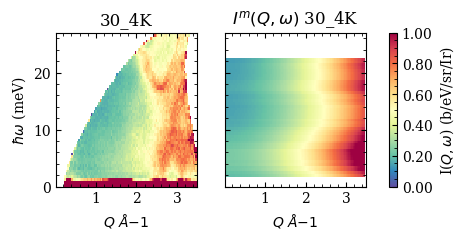

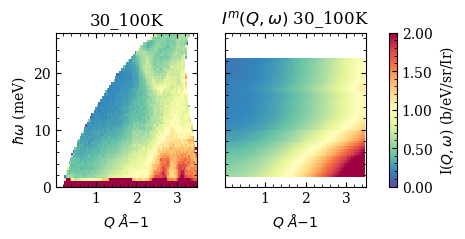

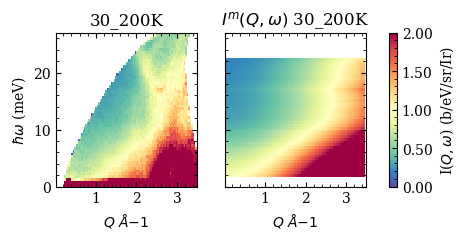

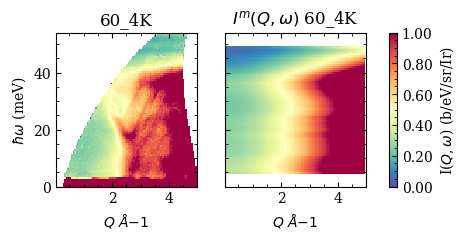

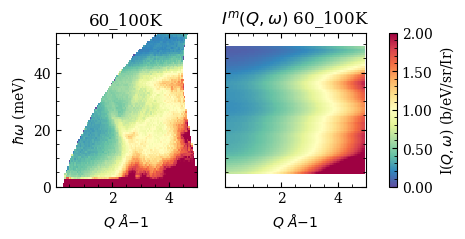

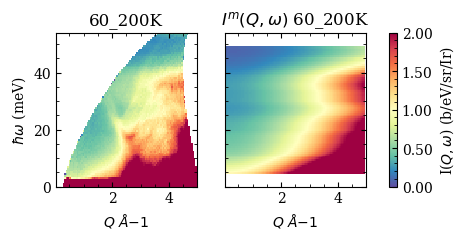

In [6]:
#Strategy is to first generate a new MDHisto workspace containing the calculated background at each temperature. 

Im_dict = {}
for i in range(len(keys)):
    key = ['30_4K','30_100K','30_200K','60_4K','60_100K','60_200K'][i]
    Ei = Ei_dict[key]
    if Ei==30.0:
        norm_qrange=[2.5,3.0]
        #norm_erange=erange_dos30
        norm_erange=[5.0,15.0]
    else:
        norm_qrange=[2.5,4.0]
        #norm_erange=erange_dos60
        norm_erange=[5.0,20.0]
    if Ei==30.0:
        Tau = T_30
    else:
        Tau = T_60
    if '_4K' in key:
        vmax = 1.0
    else:
        vmax=2.0
    edos,dos,dos_err = dos_dict[key]
    #generate a mesh of energy transfers using the original workspace to get kf, ki
    ws = mtd[key]
    dims = ws.getNonIntegratedDimensions()
    q,e = mdu.dim2array(dims[0]),mdu.dim2array(dims[1])
    Q,E = np.meshgrid(q,edos)
    lam_i = np.sqrt(81.81/Ei)
    lam_f = np.sqrt(81.81/(Ei-E))
    ki,kf = 2.0*np.pi/lam_i, 2.0*np.pi/lam_f
    kisqr_kfsqr = ki**2 + kf**2
    Ibkg = np.zeros(np.shape(Q))
    A = kisqr_kfsqr*(Tau*(Q**2 / (kisqr_kfsqr))+(1.0-Tau))
    for i in range(len(Ibkg[0])):
        Ibkg[:,i]=A[:,i]*dos
    #Mask values that do not exist in the real data
    Ibkg=Ibkg.flatten()
    #Put this into an MDhisto workspace
    extents_str = str(np.min(q))+','+str(np.max(q))+','+str(np.min(edos))+','+str(np.max(edos))
    numbin_str = str(len(np.unique(q)))+','+str(len(np.unique(edos)))
    bkg_md = CreateMDHistoWorkspace(Dimensionality=2,Extents = extents_str,SignalInput=Ibkg,\
                                   ErrorInput=np.ones(len(Ibkg)),Names='|Q|,DeltaE',\
                                    Units='MomentumTransfer,EnergyTransfer',NumberOfBins=numbin_str)
    #Normalize this background to the actual scattering
    ews,iws,errws = cut_MDHisto_powder(ws,'DeltaE',[norm_erange[0],norm_erange[1],np.abs(edos[1]-edos[0])],\
                                      [norm_qrange[0],norm_qrange[1]])
    ebkg,ibkg,errbkg = cut_MDHisto_powder(bkg_md,'DeltaE',[norm_erange[0],norm_erange[1],np.abs(edos[1]-edos[0])],\
                                      [norm_qrange[0],norm_qrange[1]])   
    int_ws = np.trapz(iws,x=ews)
    int_bkg = np.trapz(ibkg,x=ebkg)
    #Similar Ei's should share same scaling value. 
    if key in ['30_4K','60_4K']:
    #if key in keys:
        scale = int_ws/int_bkg
    print(f"Scale for {key} = {scale:.4f}")
    bkg_md*=scale
    bkg_md = CloneWorkspace(bkg_md,OutputWorkspace=key+'_Im')
    Im_dict[key]=bkg_md

    fig,ax = plt.subplots(1,2,figsize=(4,2),sharex=True,sharey=True,subplot_kw={'projection':'mantid'})
    mesh = ax[0].pcolormesh(ws,vmin=0,vmax=vmax,rasterized=True,cmap='Spectral_r')
    mesh = ax[1].pcolormesh(bkg_md,vmin=0,vmax=vmax,rasterized=True,cmap='Spectral_r')
    ax[0].set_ylim(0,Ei*0.9)
    ax[1].set_ylabel('')
    ax[0].set_ylabel('$\hbar\omega$ (meV)')
    ax[0].set_xlabel('$Q$ $\AA{-1}$')
    ax[1].set_xlabel('$Q$ $\AA{-1}$')
    ax[0].set_title(key)
    ax[1].set_title('$I^m (Q,\omega)$ '+key)
    #Add a colorbar
    l,b,w,h=ax[1].get_position().bounds
    cax = fig.add_axes([l+0.41,b,0.02,h])
    labelstr='I($Q,\omega$) (b/eV/sr/Ir)'
    cbar = plt.colorbar(mesh,orientation='vertical',cax=cax,label=labelstr)
    cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))
    fig.savefig('ImBkg_plots/Im_'+key+'.pdf',bbox_inches='tight',dpi=300)
    fig.savefig('ImBkg_plots/Im_'+key+'.png',bbox_inches='tight',dpi=300)

## Finally, extract the remaining background from each $\bar{I}(Q,\omega)$ using the calculated $I_m(Q,\omega)$

CreateMDHistoWorkspace-[Notice] CreateMDHistoWorkspace started
CreateMDHistoWorkspace-[Notice] CreateMDHistoWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CreateMDHistoWorkspace-[Notice] CreateMDHistoWorkspace started
CreateMDHistoWorkspace-[Notice] CreateMDHistoWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CreateMDHistoWorkspace-[Notice] CreateMDHistoWorkspace started
CreateMDHistoWorkspace-[Notice] CreateMDHistoWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CreateMDHistoWorkspace-[Notice] CreateMDHistoWorkspace started
CreateMDHistoWorkspace-[Notice] CreateMDHistoWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWor

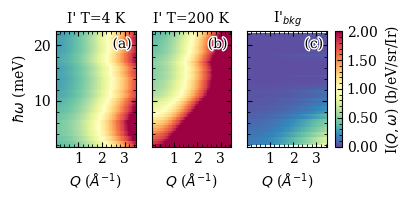

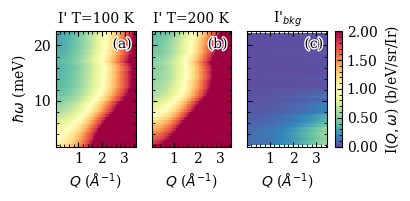

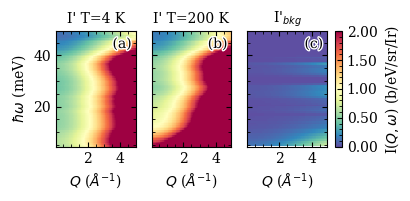

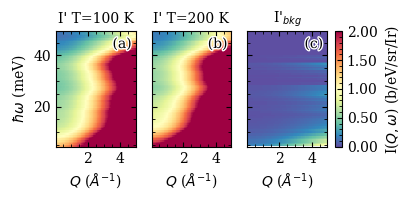

In [7]:
Im_bkg_dict = {}
for key in ['30_4K','30_100K','60_4K','60_100K']:
    Ei = Ei_dict[key]
    if Ei==30 and ('100K' in key):
        high_key = '30_200K'
        thigh=200.0
    if Ei==30 and ('4K' in key):
        high_key = '30_200K'
        thigh=200.0
    if Ei==60.0 and ('100K' in key):
        high_key= '60_200K'
        thigh=200.0
    if Ei==60.0 and ('4K' in key):
        high_key = '60_200K'
        thigh=200.0
    if '4K' in key:
        tlow=4.0
    else:
        tlow=100.0
    Ibar = Ibar_dict[key]
    Ibkg_low = Im_dict[key]
    Ibkg_high = Im_dict[high_key]
    # Unfortunately not a 1 to 1 between MDHistos, nearest-neighbor subtraction after BE scaling of high-T
    I_high = np.copy(Ibkg_high.getSignalArray())
    
    dims_high = Ibkg_high.getNonIntegratedDimensions()
    qh,eh = mdu.dim2array(dims_high[0]),mdu.dim2array(dims_high[1])
    I_low = np.copy(Ibkg_low.getSignalArray())
    dims_low = Ibkg_low.getNonIntegratedDimensions()
    ql,el = mdu.dim2array(dims_low[0]),mdu.dim2array(dims_low[1])
    Qh,Eh = np.meshgrid(qh,eh)
    Qh=Qh.T
    Eh=Eh.T
    kb=8.617e-2
    bose_mesh = (1.0-np.exp(-Eh/(kb*thigh)))/(1.0-np.exp(-Eh/(kb*tlow)))
    I_high_scale = I_high*bose_mesh
    #Now the correct background is just the difference
    Im_bkg_tot = I_low - I_high_scale
    Im_bkg_tot = Im_bkg_tot.T
    #Finally, create a new workspace to store this. 
    extents_str = str(np.min(qh))+','+str(np.max(qh))+','+str(np.min(eh))+','+str(np.max(eh))
    numbin_str = str(len(np.unique(qh)))+','+str(len(np.unique(eh)))
    Im_bkg_md = CreateMDHistoWorkspace(Dimensionality=2,Extents = extents_str,SignalInput=Im_bkg_tot.flatten(),\
                                   ErrorInput=np.ones(len(Im_bkg_tot.flatten())),Names='|Q|,DeltaE',\
                                    Units='MomentumTransfer,EnergyTransfer',NumberOfBins=numbin_str)
    Im_bkg_md = CloneWorkspace(Im_bkg_md,OutputWorkspace=key+'_bkg_tot')
    Im_bkg_dict[key]=Im_bkg_md
    fig,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(3.5,1.5),subplot_kw={'projection':'mantid'})
    ax[0].pcolormesh(Ibkg_low,vmin=0,vmax=1,cmap='Spectral_r',rasterized=True)
    ax[1].pcolormesh(Ibkg_high,vmin=0,vmax=1,cmap='Spectral_r',rasterized=True)
    ax[2].pcolormesh(Im_bkg_md,vmin=0,vmax=1,cmap='Spectral_r',rasterized=True)
    for i in [0,1,2]:
        ax[i].set_xlabel('$Q$ ($\AA^{-1}$)')
    ax[0].set_ylabel('$\hbar\omega$ (meV)')
    ax[1].set_ylabel('')
    ax[2].set_ylabel('')
    ax[0].set_title('I\' T='+key.split('_')[1][:-1]+' K',fontsize=10)
    ax[1].set_title('I\' T='+high_key.split('_')[1][:-1]+' K',fontsize=10)
    ax[2].set_title('I\'$_{bkg}$',fontsize=10)
    txta = ax[0].text(0.95,0.95,'(a)',color='k',transform=ax[0].transAxes,horizontalalignment='right',\
               verticalalignment='top',fontsize=10)
    txtb = ax[1].text(0.95,0.95,'(b)',color='k',transform=ax[1].transAxes,horizontalalignment='right',\
               verticalalignment='top',fontsize=10)
    txtc= ax[2].text(0.95,0.95,'(c)',color='k',transform=ax[2].transAxes,horizontalalignment='right',\
               verticalalignment='top',fontsize=10)
    for txt in [txta,txtb,txtc]:
        txt.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])
    #Add a colorbar
    l,b,w,h=ax[2].get_position().bounds
    cax = fig.add_axes([l+0.25,b,0.02,h])
    labelstr='I($Q,\omega$) (b/eV/sr/Ir)'
    cbar = plt.colorbar(mesh,orientation='vertical',cax=cax,label=labelstr)
    cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))
    fig.savefig('Ibkg_tot plots/'+key+"_bkg_tot.png",bbox_inches='tight',dpi=300)
    fig.savefig('Ibkg_tot plots/'+key+"_bkg_tot.pdf",bbox_inches='tight',dpi=300)
    

# Now we may finally subtract off this background from $\bar{I}(Q,\omega)$

For 30_4K scale=0.69
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duration 0.00 seconds
MultiplyMD-[Notice] MultiplyMD started
MultiplyMD-[Notice] MultiplyMD successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
SaveMD-[Notice] SaveMD started
Instrument-[Warning] Saving Instrument with no XML data. If this was instrument data you may not be able to load this data back into Mantid, for fitted/analysed data this warning can be ignored.
SaveMD-[Notice] SaveMD successful, Duration 0.10 seconds
For 30_100K scale=0.67
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duratio

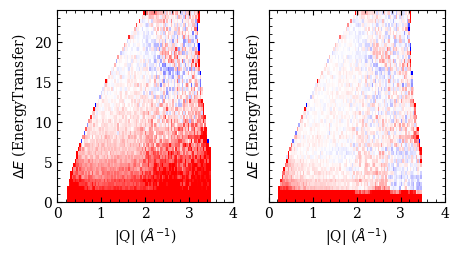

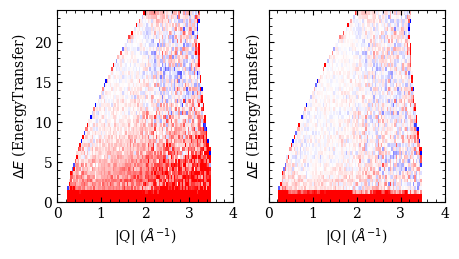

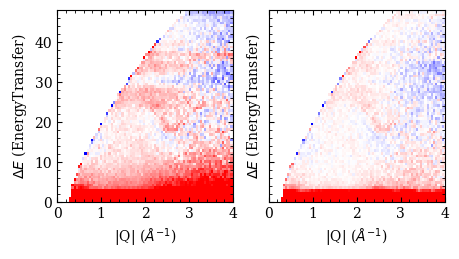

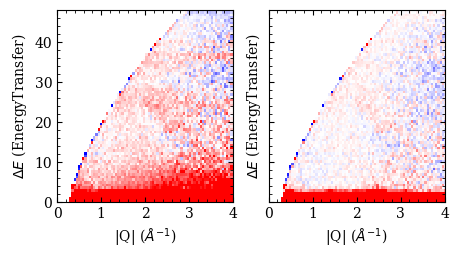

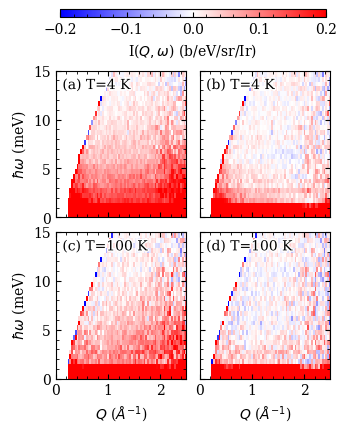

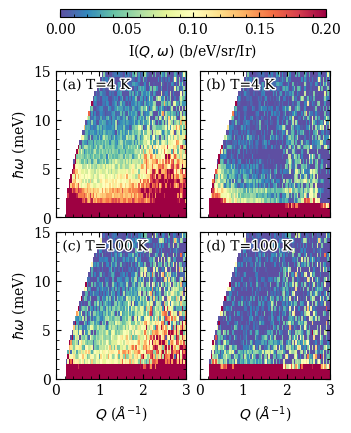

In [8]:
Imag_dict = {}
for key in ['30_4K','30_100K','60_4K','60_100K']:
    ws = Ibar_dict[key]
    Ei=Ei_dict[key]
    bkg = Im_bkg_dict[key]
    #Normalize this background to the actual scattering
    if Ei==30.0:
        norm_qrange=[2.8,3.2]
        #norm_erange=erange_dos30
        norm_erange=[2.0,10.0]
    else:
        norm_qrange=[2,3.0]
        #norm_erange=erange_dos60
        norm_erange=[10.0,20.0]
    ews,iws,errws = cut_MDHisto_powder(ws,'DeltaE',[norm_erange[0],norm_erange[1],np.abs(edos[1]-edos[0])],\
                                      [norm_qrange[0],norm_qrange[1]])
    ebkg,ibkg,errbkg = cut_MDHisto_powder(bkg,'DeltaE',[norm_erange[0],norm_erange[1],np.abs(edos[1]-edos[0])],\
                                      [norm_qrange[0],norm_qrange[1]])   
    int_ws = np.trapz(iws,x=ews)
    int_bkg = np.trapz(ibkg,x=ebkg)
    #Similar Ei's should share same scaling value. 
    #if key in ['30_4K','60_4K']:
    if key in keys:
        scale = int_ws/int_bkg
    #scale=1.0

    print(f"For {key} scale={scale:.2f}")
    bkg_clone = bkg*scale
    orig_err = np.copy(ws.getErrorSquaredArray())
    mag_ws = sub_nearest_MD(ws,bkg_clone)
    mag_ws.setErrorSquaredArray(orig_err)
    mag = CloneWorkspace(mag_ws,OutputWorkspace=key+'_mag')
    Imag_dict[key]=mtd[key+'_mag']
    
    fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(5,2.5),subplot_kw={'projection':'mantid'})
    ax[0].pcolormesh(ws,vmin=-0.2,vmax=0.2,cmap='bwr',rasterized=True)
    ax[1].pcolormesh(mag_ws,vmin=-0.3,vmax=0.3,cmap='bwr')
    ax[0].set_ylim(0,Ei*0.8)
    ax[0].set_xlim(0,4)
    fig.savefig('Imag_plots/'+key+'.pdf',bbox_inches='tight',dpi=300)
    #Save the mdhistos for analysis in a later notebook
    SaveMD(mtd[key+'_mag'],'../MDHisto_files/'+key+'_SEQ_mag.nxs')
#Make a nicer figure showing this for the Ei=30 meV measurements
cmap='bwr'
vmin=-0.2
vmax=0.2
fig,ax = plt.subplots(2,2,figsize=(3.54,4.0),subplot_kw={'projection':'mantid'},sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.1,wspace=0.1)

ax[0,0].pcolormesh(Ibar_dict['30_4K'],vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)
ax[1,0].pcolormesh(Ibar_dict['30_100K'],vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)

txta=ax[0,0].text(0.05,0.95,'(a) T=4 K',transform=ax[0,0].transAxes,horizontalalignment='left',verticalalignment='top')
txtc=ax[1,0].text(0.05,0.95,'(c) T=100 K',transform=ax[1,0].transAxes,horizontalalignment='left',verticalalignment='top')
txtb=ax[0,1].text(0.05,0.95,'(b) T=4 K',transform=ax[0,1].transAxes,horizontalalignment='left',verticalalignment='top')
txtd=ax[1,1].text(0.05,0.95,'(d) T=100 K',transform=ax[1,1].transAxes,horizontalalignment='left',verticalalignment='top')
for txt in [txta,txtb,txtc,txtd]:
    txt.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

ax[0,1].pcolormesh(Imag_dict['30_4K'],vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)
mesh=ax[1,1].pcolormesh(Imag_dict['30_100K'],vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)

ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[1,1].set_ylabel('')
ax[1,0].set_ylabel('$\hbar\omega$ (meV)')
ax[0,0].set_ylabel('$\hbar\omega$ (meV)')
ax[1,0].set_xlabel('$Q$ ($\AA^{-1}$)')
ax[1,1].set_xlabel('$Q$ ($\AA^{-1}$)')

ax[0,1].set_ylabel('')
ax[0,0].set_ylim(0,15)
ax[0,0].set_xlim(0,2.5)

#Add a colorbar
l,b,w,h=ax[0,0].get_position().bounds
cax = fig.add_axes([l+0.0125,b+0.5,0.75,0.02])
labelstr='I($Q,\omega$) (b/eV/sr/Ir)'
cbar = plt.colorbar(mesh,orientation='horizontal',cax=cax,label=labelstr)
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))
fig.savefig('HLIO_magsub.pdf',bbox_inches='tight',dpi=300)

#Make a nicer figure showing this for the Ei=30 meV measurements
cmap='Spectral_r'
vmin=0.0
vmax=0.2
fig,ax = plt.subplots(2,2,figsize=(3.54,4.0),subplot_kw={'projection':'mantid'},sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.1,wspace=0.1)

ax[0,0].pcolormesh(Ibar_dict['30_4K'],vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)
ax[1,0].pcolormesh(Ibar_dict['30_100K'],vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)

txta=ax[0,0].text(0.05,0.95,'(a) T=4 K',transform=ax[0,0].transAxes,horizontalalignment='left',verticalalignment='top')
txtc=ax[1,0].text(0.05,0.95,'(c) T=100 K',transform=ax[1,0].transAxes,horizontalalignment='left',verticalalignment='top')
txtb=ax[0,1].text(0.05,0.95,'(b) T=4 K',transform=ax[0,1].transAxes,horizontalalignment='left',verticalalignment='top')
txtd=ax[1,1].text(0.05,0.95,'(d) T=100 K',transform=ax[1,1].transAxes,horizontalalignment='left',verticalalignment='top')

for txt in [txta,txtb,txtc,txtd]:
    txt.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

ax[0,1].pcolormesh(Imag_dict['30_4K'],vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)
mesh=ax[1,1].pcolormesh(Imag_dict['30_100K'],vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)

ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[1,1].set_ylabel('')
ax[1,0].set_ylabel('$\hbar\omega$ (meV)')
ax[0,0].set_ylabel('$\hbar\omega$ (meV)')
ax[1,0].set_xlabel('$Q$ ($\AA^{-1}$)')
ax[1,1].set_xlabel('$Q$ ($\AA^{-1}$)')

ax[0,1].set_ylabel('')
ax[0,0].set_ylim(0,15)
ax[0,0].set_xlim(0,3)

#Add a colorbar
l,b,w,h=ax[0,0].get_position().bounds
cax = fig.add_axes([l+0.0125,b+0.5,0.75,0.02])
labelstr='I($Q,\omega$) (b/eV/sr/Ir)'
cbar = plt.colorbar(mesh,orientation='horizontal',cax=cax,label=labelstr)
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))
fig.savefig('HLIO_magsub_2.pdf',bbox_inches='tight',dpi=300)

## Finally, make a comparison using a cut.

In [9]:
%matplotlib inline
plt.close('all')

[ 2.46296387  3.7888916   5.11481934  6.44074707  7.7666748   9.09260254
 10.41853027 11.74445801 13.07038574 14.39631348 15.72224121 17.04816895
 18.37409668 19.70002441 21.02595215 22.35187988 23.67780762 25.00373535
 26.32966309 27.65559082 28.98151855 30.30744629 31.63337402 32.95930176
 34.28522949 35.61115723 36.93708496 38.2630127  39.58894043]


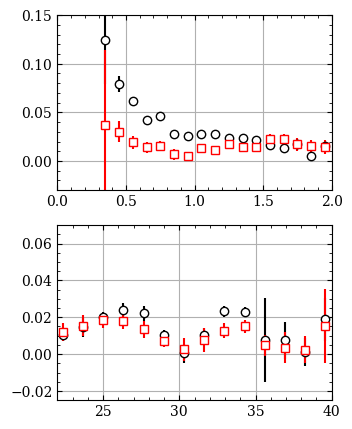

In [10]:
#Begin with cuts as a check. 

dims = Imag_dict['60_4K'].getNonIntegratedDimensions()
e=mdu.dim2array(dims[1])
eres = np.abs(e[1]-e[0])

#Cuts showing quality of subtractions
fig,ax = plt.subplots(2,1,figsize=(3.54,5))
ecut_low = 2
ecut_high = 6
qcut30,iqcut30,errqcut30 = cut_MDHisto_powder(Imag_dict['30_4K'],'|Q|',[0,3.5,0.1],[ecut_low,ecut_high])
qcut30H,iqcut30H,errqcut30H = cut_MDHisto_powder(Imag_dict['30_100K'],'|Q|',[0,3.5,0.1],[ecut_low,ecut_high])
ax[0].errorbar(qcut30,iqcut30,yerr=errqcut30,color='k',marker='o',mfc='w',mec='k',ls=' ')
ax[0].errorbar(qcut30H,iqcut30H,yerr=errqcut30H,color='r',marker='s',mfc='w',mec='r',ls=' ')
ax[0].grid('on')
ax[0].set_ylim(-0.03,0.15)
ax[0].set_xlim(0,2)

qcut_low = 0.4
qcut_high = 3.0
ecut30,iecut30,errecut30 = cut_MDHisto_powder(Imag_dict['60_4K'],'DeltaE',[1.8,40,eres*2],[qcut_low,qcut_high])
ecut30H,iecut30H,errecut30H = cut_MDHisto_powder(Imag_dict['60_100K'],'DeltaE',[1.8,40,eres*2],[qcut_low,qcut_high])
#ecut30,iecut30,errecut30 = cut_MDHisto_powder(mtd['60_4K'],'DeltaE',[1.8,40,eres*2],[qcut_low,qcut_high])
#ecut30H,iecut30H,errecut30H = cut_MDHisto_powder(mtd['60_100K'],'DeltaE',[1.8,40,eres*2],[qcut_low,qcut_high])

print(ecut30)
ax[1].errorbar(ecut30,iecut30,yerr=errecut30,color='k',marker='o',mfc='w',mec='k',ls=' ')
ax[1].errorbar(ecut30H,iecut30H,yerr=errecut30H,color='r',marker='s',mfc='w',mec='r',ls=' ')
ax[1].grid('on')
ax[1].set_ylim(-0.025,0.07)
ax[1].set_xlim(22,40)

plt.show()